# Analytics - query to reference mapping  

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [1]:
import scvi
import mplscience
import matplotlib.pyplot as plt
import os
import pynndescent
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scvi.data._download import _download
import anndata

scvi.settings.seed = 1

# plotting commands for the styling
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 1


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

## 1️⃣ Download the pre-trained model

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [2]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref"

In [3]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

INFO     Downloading file at                                                                                       
         /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/model.pt               
Downloading...: 100%|██████████| 5867/5867.0 [00:00<00:00, 8029.05it/s]


## 2️⃣ Download the query data

For the query, we will use samples from the following publication:  

- Delorey, Toni M., et al. “COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets.” Nature 595.7865 (2021): 107-113.

In [4]:
%%capture
%%bash
curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz -o "query.h5.gz"
gzip -df query.h5.gz

In [5]:
geo_metadata_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz"
metadata = pd.read_csv(geo_metadata_url, index_col=0)
query_data = sc.read_10x_h5("query.h5")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
query_data.var

,gene_ids,feature_types,genome
GRCh38___MIR1302-2HG,GRCh38___ENSG00000243485,Gene Expression,GRCh38
GRCh38___FAM138A,GRCh38___ENSG00000237613,Gene Expression,GRCh38
GRCh38___OR4F5,GRCh38___ENSG00000186092,Gene Expression,GRCh38
GRCh38___AL627309.1,GRCh38___ENSG00000238009,Gene Expression,GRCh38
GRCh38___AL627309.3,GRCh38___ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
SARSCoV2_SARSCoV2_ORF8,SARSCoV2_SARSCoV2_ORF8,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_N,SARSCoV2_SARSCoV2_N,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_ORF10,SARSCoV2_SARSCoV2_ORF10,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_3prime,SARSCoV2_SARSCoV2_3prime,Gene Expression,SARSCoV2


In [7]:
# need gene ids as index to match the core HLCA data
query_data.var['gene_names'] = query_data.var.index
query_data.var.index = [idx.split("___")[-1] for idx in query_data.var.gene_ids]

In [8]:
# use metadata to select only cells of interest and remove empty drops
metadata = metadata.loc[metadata.donor == "D12_4",:].copy()
metadata.index = [idx.split("-")[-1] for idx in metadata.index]
# subset query_data to cells in metadata
query_data.obs.index = query_data.obs.index.str.rstrip("-1")
query_data = query_data[metadata.index, :].copy()

In [9]:
# add dataset information:
query_data.obs['dataset'] = "test_dataset_delorey_regev"

In [10]:
query_data

AnnData object with n_obs × n_vars = 1786 × 33567
    obs: 'dataset'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [11]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/model.pt already  
         downloaded                                                                                                
INFO     Found 99.65% reference vars in query data.                                                                


/Users/valehvpa/GitRepos/scvi-tools/scvi/model/base/_archesmixin.py:222: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [12]:
query_data.obs["scanvi_label"] = "unlabeled"

In [13]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/model.pt already  
         downloaded                                                                                                


In [14]:
query_model.adata

AnnData object with n_obs × n_vars = 1786 × 2000
    obs: 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

Train the query model.

In [15]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [16]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 277/500:  55%|█████▌    | 277/500 [02:10<01:45,  2.12it/s, v_num=1, train_loss_step=547, train_loss_epoch=510]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 541.602. Signaling Trainer to stop.


In [17]:
query_save_path = f"{local_dir}/query_model"
query_model.save(query_save_path, overwrite=True)

In [18]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

## 4️⃣ Learn a neighbors index on reference latent space  

Get the "latent space" from our embeddings. It is essentially just the mean of the latent distribution.

In [19]:
fname = "HLCA_full_v1.1_emb.h5ad"
adata = sc.read(os.path.join(local_dir, fname), backup_url=f"https://zenodo.org/record/7599104/files/{fname}")
adata = adata[adata.obs["core_or_extension"] == "core"].copy()

In [20]:
ref = adata.X
ref_nn_index = pynndescent.NNDescent(ref)
ref_nn_index.prepare()

## 5️⃣ Predict cell types

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [21]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

In [22]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### Predict

In [23]:
label_key = "ann_level_3"
ref_cats = adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(adata.obs[label_key].cat.categories)[p]
query_emb.obs["celltype_pred"], query_emb.obs["celltype_uncertainty"] = p, u

### Evaluate predictions

Finally, let's evaluate predictions.

In [24]:
query_emb.obs[["celltype_pred", "celltype_uncertainty"]]

,celltype_pred,celltype_uncertainty
AAGCGTTTCAGTGCGC,Lymphatic EC mature,0.399993
AGCCACGAGGAGTCTG,Lymphatic EC mature,0.400029
ATCATTCGTATTTCGG,Lymphatic EC differentiating,0.200081
TGGCGTGCATGTAACC,Lymphatic EC mature,0.099992
CTACAGACACTGTGAT,EC venous,0.000000
...,...,...
TGATGCACATGGGCAA,AT1,0.000000
AATGACCAGCCGATTT,T cell lineage,0.000000
CTCCATGCACTCTAGA,Fibroblasts,0.000000
ATGGGTTAGAGGCGTT,AT1,0.200000


0.03656146507647644 5.960464477539063e-08


<AxesSubplot: ylabel='Density'>

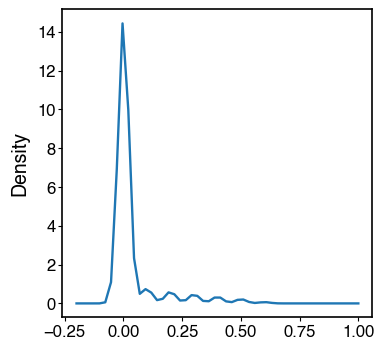

In [25]:
print(query_emb.obs["celltype_uncertainty"].mean(), np.quantile(query_emb.obs["celltype_uncertainty"], 0.75))
query_emb.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

In [26]:
def get_comparison_df(uncertainty_threshold = None):
    # build comparison_df
    assert metadata["predicted_celltype"].index.equals(query_emb.obs.index)
    comparison_df = pd.DataFrame(index=metadata["predicted_celltype"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_emb.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_emb.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = metadata["predicted_celltype"].fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty > {uncertainty_threshold}")

    return comparison_df

In [27]:
comparison_df = get_comparison_df(uncertainty_threshold=0.2)

filtered out 6 barcodes (0.34%) with unknown ground truth
filtered out 138 barcodes (7.75%) with pred uncertainty > 0.2


## 6️⃣ Plot
Let's plot heatmap

In [28]:
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"

In [29]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100

In [33]:
comparison_df["pred"].value_counts()

Fibroblasts                     1062
EC capillary                     172
EC venous                        162
T cell lineage                    63
AT1                               60
Lymphatic EC differentiating      35
EC arterial                       27
Macrophages                       18
Lymphatic EC mature               14
B cell lineage                     9
Mast cells                         6
None                               6
AT2                                3
Innate lymphoid cell NK            2
Myofibroblasts                     2
Monocytes                          1
Name: pred, dtype: int64

Some notes on the new HLCA annotations (https://zenodo.org/record/6337966/ vs https://zenodo.org/record/7599104):
- All new 60 cells have None for ann_level_3 annotations.
- No cells was predicted as "Smooth muscle FAM83D+" (even before thresholding on prediction uncertainty)
- In prev ann_level_3, not in new: 'Fibromyocytes'
- In new ann_level_3, not in prev: 'Smooth muscle FAM83D+'
- Only 565 cells differ between prev and new ann_level_3 annotations and their distribution is (prev, new):  
Fibromyocytes,Smooth muscle FAM83D+   -> 335  
Secretory,AT2                       ->   230

<AxesSubplot: xlabel='True label', ylabel='Predicted label'>

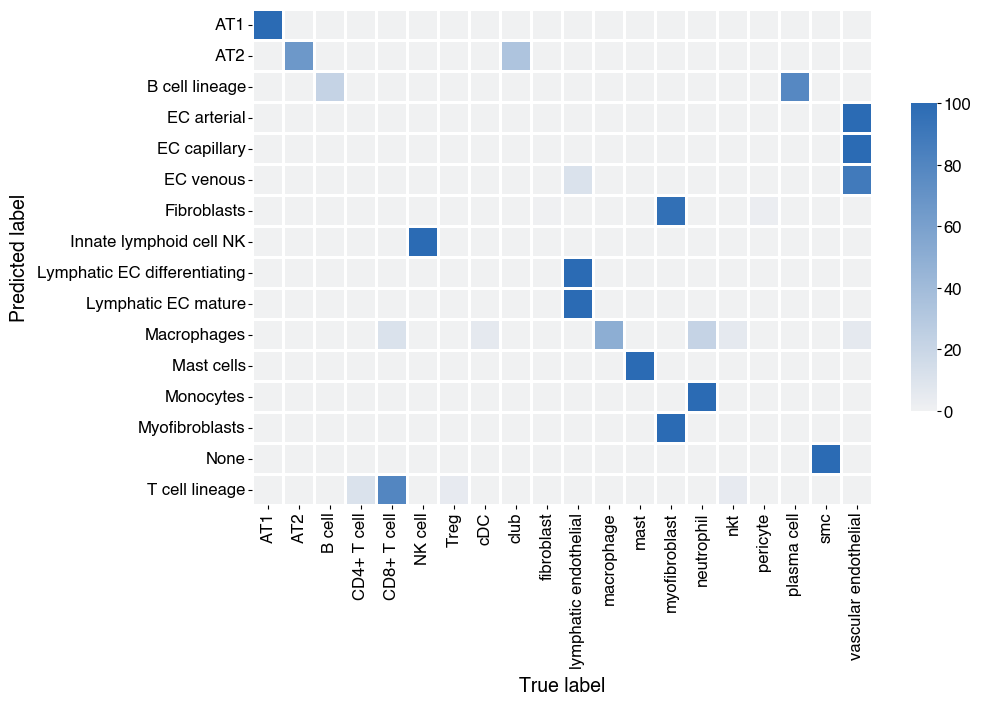

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix,
    # cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    linecolor='white',
    linewidths=1, 
    # annot=True,
)

In [69]:
# reorder rows and cols to make it look more diagonal

new_rows = [
    "AT1",
    "AT2",
    "B cell lineage",
    "EC arterial",
    "EC capillary",
    "EC venous",
    "Lymphatic EC differentiating",
    "Lymphatic EC mature",
    "Fibroblasts",
    "Myofibroblasts",
    "Innate lymphoid cell NK",
    "Macrophages",
    "Monocytes",
    "Mast cells",
    "T cell lineage",
    "None",
]

new_cols = [
    "AT1",
    "AT2",
    "club",
    "B cell",
    "plasma cell",
    "vascular endothelial",
    "lymphatic endothelial",
    "fibroblast",
    "myofibroblast",
    "NK cell",
    "macrophage",
    "neutrophil",
    "mast",
    "CD8+ T cell",
    "CD4+ T cell",
    "smc",
    "Treg",
    "nkt",
    "cDC",
    "pericyte",
]

confusion_matrix_reordered = confusion_matrix.loc[new_rows, new_cols]

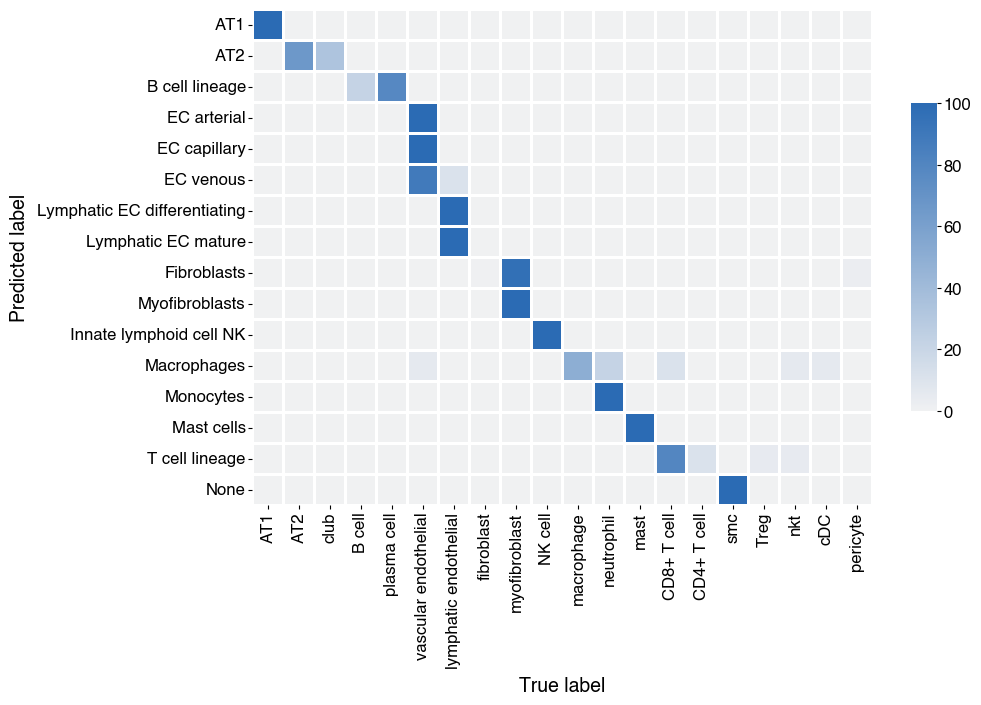

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix_reordered,
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    linecolor='white',
    linewidths=1, 
)

temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"
fig_path = f'{temp_fig_dir}/celltype_preds.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

Note: pericyte and fibroblast columns appear empty. In reality, all of those cells have Fibroblasts prediction with a low enough prediction uncertainty. However, the marjory if cells with Fibroblasts prediction have a ground truth pred of myofibroblast. Below is the distribution of these cell types. Since (Fibroblasts, myofibroblast) is 95% and we are showing percentages on the heatmap above, the remaining 5% -- which is further distrusted across multiple different cell types -- is not visible.  

myofibroblast           1029  
pericyte                  28  
fibroblast                 8  
smc                        5  
vascular endothelial       3  
club                       3  
Unknown                    1  
Name: ground_truth, dtype: int64  

In [108]:
len(comparison_df["ground_truth"].astype("category").cat.categories), len(comparison_df["pred"].astype("category").cat.categories)

(20, 16)

## 7️⃣ Visualize embeddings in the joint latent space

Combine embeddings

In [110]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'celltype_pred', 'celltype_uncertainty', 'dataset'

In [121]:
reference_emb = sc.AnnData(adata.X)
reference_emb.obs_names = adata.obs_names
reference_emb.obs["dataset"] = adata.obs.dataset
reference_emb

AnnData object with n_obs × n_vars = 584944 × 30
    obs: 'dataset'

In [126]:
combined_emb = reference_emb.concatenate(query_emb)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [128]:
combined_emb.obs["batch"].value_counts()

0    584944
1      1786
Name: batch, dtype: int64

In [132]:
combined_emb

AnnData object with n_obs × n_vars = 586730 × 30
    obs: 'dataset', 'celltype_pred', 'celltype_uncertainty', 'batch'

Visualize embeddings.

I do this on a device with more ram, but you can run it locally if you have enough ram.

In [136]:
# combined_emb.write_h5ad(f"{local_dir}/combined_emb.h5ad")

# import scanpy as sc
# import anndata
# combined_emb = anndata.read_h5ad("combined_emb.h5ad")
# sc.pp.neighbors(combined_emb, use_rep="X")
# sc.tl.umap(combined_emb, min_dist=0.3)
# combined_emb.write_h5ad("combined_emb_umap.h5ad")

combined_emb_umap = anndata.read_h5ad(f"{local_dir}/combined_emb_umap.h5ad")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


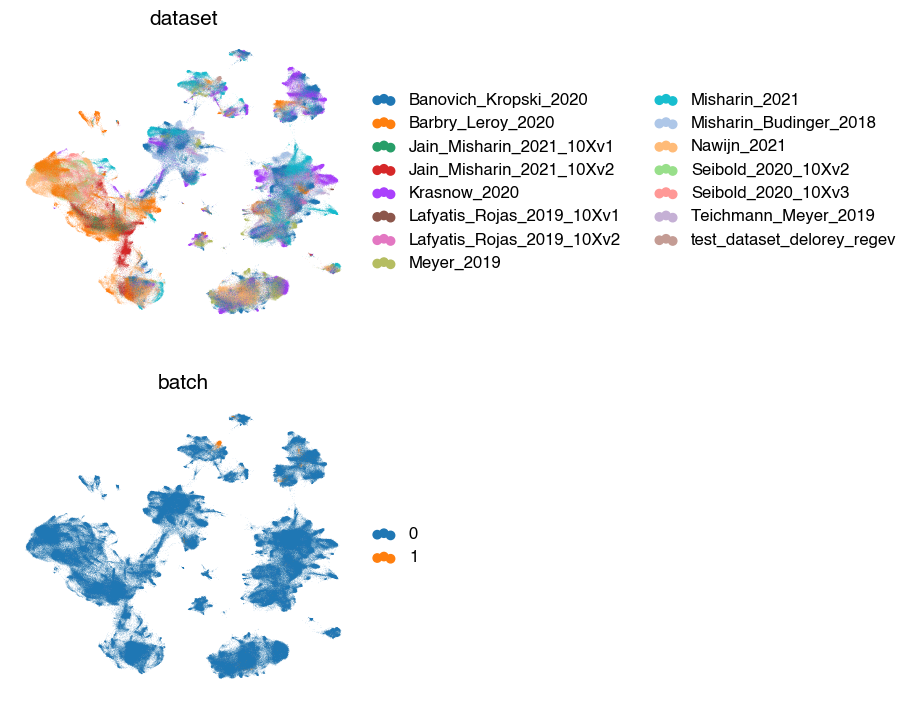

In [137]:
sc.pl.umap(
    combined_emb_umap,
    color=["dataset", "batch"],
    ncols=1,
    frameon=False,
)

Let's plot only batch. It is 1:1 equivalent with the dataset anyway as can be seen below.

In [138]:
idx1 = combined_emb_umap.obs["batch"] == "1"
idx2 = combined_emb_umap.obs["dataset"] == "test_dataset_delorey_regev"
assert idx1.equals(idx2)

In [139]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [140]:
df = combined_emb_umap.obs
default_size = 120000 / len(df) # default scanpy
df["umap_size"] = default_size * 10
df.loc[df["batch"] == "1", "umap_size"] = default_size * 10 # if you want to make the query dataset points bigger
combined_emb_umap.obs = df

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


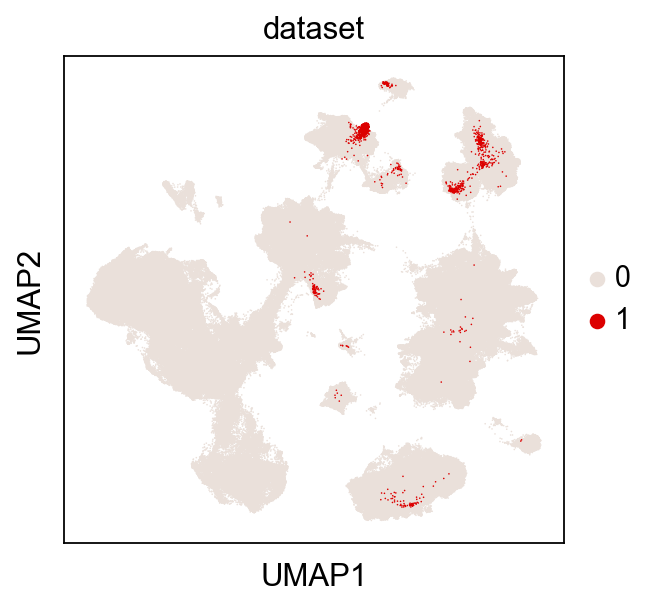

In [141]:
custom_pal = {"0": "#EAE0DA", "1": "#DC0000"}
sc.pl.umap(
    combined_emb_umap,
    color=["batch"],
    ncols=1,
    frameon=True,
    save="combined_umap_batch.svg",
    palette=custom_pal,
    size=combined_emb_umap.obs["umap_size"],
    title="dataset"
)

## DEBUGGING

In [37]:
import gc
import anndata
p1 = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/old/data_stuff/HLCA/hlca_new/HLCA_emb_and_metadata.h5ad"
p2 = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref_old/temp_manual_backup/HLCA_full_v1.1_emb.h5ad"
adata1 = anndata.read_h5ad(p1)
t = anndata.read_h5ad(p2)
adata2 = t[t.obs["core_or_extension"] == "core"].copy()
del t
gc.collect()

In [53]:
idx_diff = adata2.obs.index.difference(adata1.obs.index)
idx_common = adata2.obs.index.difference(idx_diff)
ann_1 = adata1.obs.loc[idx_common]["ann_level_3"].astype("str")
ann_2 = adata2.obs.loc[idx_common]["ann_level_3"].astype("str")
ann_1.name = "ann_1"
ann_2.name = "ann_2"
df = pd.concat([ann_1, ann_2], axis=1)
df["ann_1,ann_2"] = df["ann_1"] + "," + df["ann_2"]

In [54]:
df[ann_1 != ann_2]["ann_1,ann_2"].value_counts()
# in 2 not in 1: 'Smooth muscle FAM83D+',
# in 1 not in 2: 'Fibromyocytes',

Fibromyocytes,Smooth muscle FAM83D+    335
Secretory,AT2                          230
Name: ann_1,ann_2, dtype: int64

In [68]:
i = query_emb.obs["celltype_pred"] == "SM activated stress response"
query_emb.obs.loc[i, ["celltype_pred", "celltype_uncertainty"]]

,celltype_pred,celltype_uncertainty
GAGACTTCAAGACCTT,SM activated stress response,0.30005


In [77]:
query_emb.obs

,celltype_pred,celltype_uncertainty
AAGCGTTTCAGTGCGC,Lymphatic EC mature,0.399993
AGCCACGAGGAGTCTG,Lymphatic EC mature,0.400029
ATCATTCGTATTTCGG,Lymphatic EC differentiating,0.200081
TGGCGTGCATGTAACC,Lymphatic EC mature,0.099992
CTACAGACACTGTGAT,EC venous,0.000000
...,...,...
TGATGCACATGGGCAA,AT1,0.000000
AATGACCAGCCGATTT,T cell lineage,0.000000
CTCCATGCACTCTAGA,Fibroblasts,0.000000
ATGGGTTAGAGGCGTT,AT1,0.200000


In [76]:
metadata["predicted_celltype"].value_counts()

myofibroblast            1031
vascular endothelial      415
lymphatic endothelial      97
AT1                        62
CD8+ T cell                57
pericyte                   28
club                       12
smc                        12
macrophage                 10
nkt                         8
fibroblast                  8
CD4+ T cell                 7
neutrophil                  7
plasma cell                 7
mast                        6
NK cell                     4
Treg                        3
B cell                      2
cDC                         2
AT2                         2
Name: predicted_celltype, dtype: int64

In [80]:
metadata["predicted_celltype"]

AAGCGTTTCAGTGCGC    lymphatic endothelial
AGCCACGAGGAGTCTG    lymphatic endothelial
ATCATTCGTATTTCGG    lymphatic endothelial
TGGCGTGCATGTAACC    lymphatic endothelial
CTACAGACACTGTGAT    lymphatic endothelial
                            ...          
TGATGCACATGGGCAA                      NaN
AATGACCAGCCGATTT                      NaN
CTCCATGCACTCTAGA                      NaN
ATGGGTTAGAGGCGTT                      NaN
CGTGTCTCACGCTGTG                      NaN
Name: predicted_celltype, Length: 1786, dtype: object

In [81]:
dddd = pd.DataFrame(index=metadata["predicted_celltype"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
dddd["pred"] = query_emb.obs["celltype_pred"]
dddd["pred_uncertainty"] = query_emb.obs["celltype_uncertainty"]
dddd["ground_truth"] = metadata["predicted_celltype"].fillna("Unknown")

In [109]:
# dddd[dddd["ground_truth"] == "pericyte"]["pred"].value_counts()
dddd[dddd["pred"] == "Fibroblasts"]["ground_truth"].value_counts()

myofibroblast           1029
pericyte                  28
fibroblast                 8
smc                        5
vascular endothelial       3
club                       3
Unknown                    1
Name: ground_truth, dtype: int64

In [106]:
10 / 23

0.43478260869565216